# Hysteresis

In this section, we illustrate the complex phenomenon of hysteresis in CRLD. Hysteresis means that the system's state depends on the history of external parameter changes. Here, we show that hysteresis exists by varying the discount factor, which indicates how much the agents care for future rewards. We let the discount factor increase and decrease again while the CRLD keeps running.

First, we import everything we need:

In [5]:
#| echo: false
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 180

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from pyCRLD.Environments.EcologicalPublicGood import EcologicalPublicGood as EPG
from pyCRLD.Agents.StrategySARSA import stratSARSA as stratS

In contrast to the previous examples, where we used `stratAC`, i.e., actor-critic learning agents in strategy space, we use `stratSARSA` agents, as seen above in the imports. The SARSA agents differ from the actor-critic learners in their exploration terms. The SARSA agents keep a constant exploration term, which prevents them from converging too close to the edges of the strategy phase space. They are constantly exploring to some extent. Keeping a small distance to the edges of the strategy phase space is required for hysteresis. When the external parameter changes while CRLD keeps running, the agents need to be able to change their current equilibrium. Otherwise, no change of equilibrium is observable. 

To be able to change their current equilibrium requires the agents to keep a small distance from the strategy phase space edges, as one can also see in the learning update equation, 


$$
 X^i_{t+1}(s, a) = \frac{1}{\bar{\mathfrak{Z}}^i(s)} X^i_t(s, a) \exp\big(\eta^i \cdot \bar \delta^i(s, a) \big).
$$

If $X^i_t(s, a)$ is too close to zero or one, no update can happen, regardless of the strategy-average reward-prediction error $\bar \delta^i_t(s, a)$. See @BarfussEtAl2019 for a detailed comparison between the CRLD of SARSA and actor-critic learning.

By trial-and-error, we set the choice intensity of SARSA learning to 60 log-probils per util.

## Compute data
First, we compute the data for the hysteresis curve.

In [3]:
#| output: false

# Set up the ecological public goods environment
env = EPG(N=2, f=1.2, c=5, m=-5, qc=0.2, qr=0.01, degraded_choice=False)

# Compile the list of discount factors 
dcfs = list(np.arange(0.6, 0.9, 0.005))
# Hysteresis curve parameters first increase and then decrease again
hystcurve = dcfs + dcfs[::-1]

coops = []  # for storing the cooperation probabilities
for i, dcf in enumerate(hystcurve):
    # Adjust multi-agent environment interface with discount factor
    MAEi = stratS(env=env, discount_factors=dcf, use_prefactor=True,
                learning_rates=0.01, choice_intensities=60)
    if i==0: # Choose random intial policy 
        X = MAEi.random_softmax_strategy()
        
    # Compute trajectory
    trj, fpr = MAEi.trajectory(X, Tmax=2500, tolerance=10e-12)
    print('\r ', dcf, fpr, end=' ')
    X = trj[-1] # select last strategy
    coops.append(X[:, 1, 0]) # append to storage container

  0.6 True e 0000001 True  

## Plot curve
Now, we plot the computed data. We use the points' size and color to indicate the time dimensions of the discount factor changes. The time flows from big to small data points and from dark to light ones.

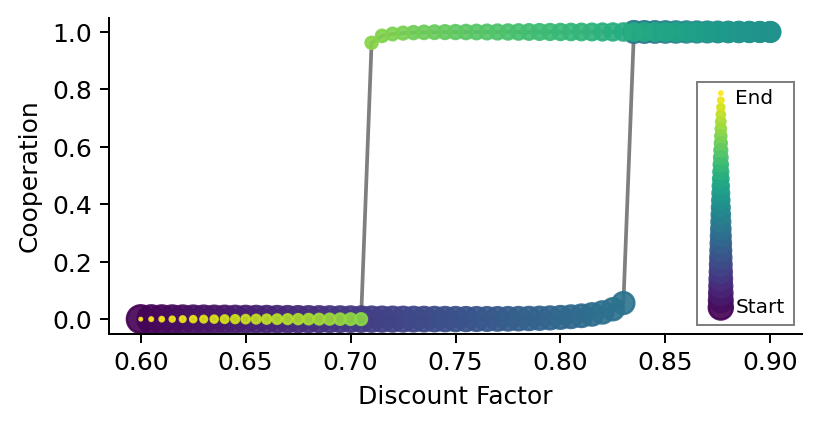

In [7]:
#| fig-cap: "Hysteresis curve"

# Create the canves
fsf = 0.75  # figure size factor
plt.figure(figsize=(fsf*6, fsf*3))    

# Plot background line
plt.plot(hystcurve, np.array(coops).mean(-1),'-',alpha=0.5,color='k',zorder=-1)
# Plot data points with size and color indicating the time dimension
plt.scatter(hystcurve, np.array(coops).mean(-1), alpha=0.9,
            s=np.arange(len(hystcurve))[::-1]+1, c=np.arange(len(hystcurve)))

# Make labels and axis nice
plt.ylabel('Cooperation')
plt.xlabel('Discount Factor')
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# Legend
ax = plt.gcf().add_axes([0.85, 0.22, 0.12, 0.6])
# ax = plt.gcf().add_axes([0.135, 0.38, 0.12, 0.6])
ax.scatter(np.ones_like(hystcurve)[::4], np.arange(len(hystcurve))[::4], alpha=0.9, 
           s=0.75*np.arange(len(hystcurve))[::-1][::4]+1, c=np.arange(len(hystcurve))[::4])
# ax.annotate('Time', xy=(0.5, 1.07), xycoords='axes fraction', va='center', ha='center', fontsize=9)
ax.annotate('Start', xy=(1.6, 0), xycoords='data', va='center', ha='left', fontsize=8)
ax.annotate('End', xy=(1.6, len(hystcurve)-5), xycoords='data', va='center', ha='left', fontsize=8)
ax.set_ylim(-10,); ax.set_xlim(0,4)
ax.set_yticks([]); ax.set_xticks([])
for spine in ax.spines.values(): spine.set_edgecolor('grey')

# Save plot
plt.subplots_adjust(left=0.125, right=0.98, top=0.98, bottom=0.2)
plt.savefig("_figs/fig_03Hysteresis.png", dpi=150)

As one can see, when the discount factor starts to increase, the learners remain close to defection up to the critical point of about 0.83 when they suddenly switch to complete cooperation. However, when the discount factor starts to decrease again, they remain at almost full cooperation until a much smaller value of approx. 0.71. Only then do the agents suddenly become complete defectors again.